# UiBench benchmark on Android

This benchmark is used to evaluate the responsiveness of an Android system to user interaction. Also **systraces** are captured during the benchmark run and represented at the end of the notebook.

In [1]:
import logging

from conf import LisaLogging
LisaLogging.setup()

2017-09-07 02:47:06,779 INFO    : root         : Using LISA logging configuration:
2017-09-07 02:47:06,781 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload, System

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Get workload
    wload = Workload.getInstance(te, 'UiBench')
        
    # Run UiBench
    wload.run(te.res_dir, test_name='TrivialAnimationActivity', duration_s=10, collect='ftrace')
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

#     # Target platform and board
#     "platform"     : 'android',
#     "board"        : 'pixel',
    
#     # Device
#     "device"       : "FA6A10306347",
    
#     # Android home
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Folder where all the results will be collected
    "results_dir" : "UiBench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2017-09-07 02:47:10,233 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-09-07 02:47:10,234 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-09-07 02:47:10,236 INFO    : TestEnv      : External tools using:
2017-09-07 02:47:10,237 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-09-07 02:47:10,238 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-09-07 02:47:10,240 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-09-07 02:47:10,241 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-09-07 02:47:10,243 INFO    : TestEnv      : Connection settings:
2017-09-07 02:47:10,244 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-09-07 02:47:10,863 INFO    : TestEnv      : Initializing target workdir:
2017-09-07 02:47:10,865 INFO    : TestEnv      :    /data/local/tmp/devlib-target
2017-09-07 02:47:12,496 INFO    : TestEnv  

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **UiBench - TrivialAnimation** experiment.

In [6]:
# Intialize Workloads for this test environment
results = experiment()

2017-09-07 02:47:15,557 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.antutu.benchmark.full', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.android.providers.settings', 'com.android.sharedstoragebackup', 'com.android.printspooler', 'com.android.dreams.basic', 'com.android.webview', 'com.android.inp

2017-09-07 02:47:35,923 INFO    : UiBench      : FTrace STOP
2017-09-07 02:47:38,792 INFO    : System       : am force-stop com.android.test.uibench
2017-09-07 02:47:39,738 INFO    : Screen       : Set orientation: AUTO
2017-09-07 02:47:41,150 INFO    : Screen       : Set brightness: AUTO


## Benchmarks results

In [9]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 2442779126188ns
Total frames rendered: 949
Janky frames: 279 (29.40%)
50th percentile: 11ms
90th percentile: 18ms
95th percentile: 19ms
99th percentile: 20ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [10]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2017-09-07 02:48:21,766 INFO    : Trace        : Platform clusters verified to be Frequency coherent


2017-09-07 02:48:41,685 INFO    : Analysis     : LITTLE cluster average frequency: 1.312 GHz
2017-09-07 02:48:41,686 INFO    : Analysis     : big    cluster average frequency: 0.934 GHz
2017-09-07 02:48:41,690 INFO    : root         : Plotting cluster frequencies for [sched]...


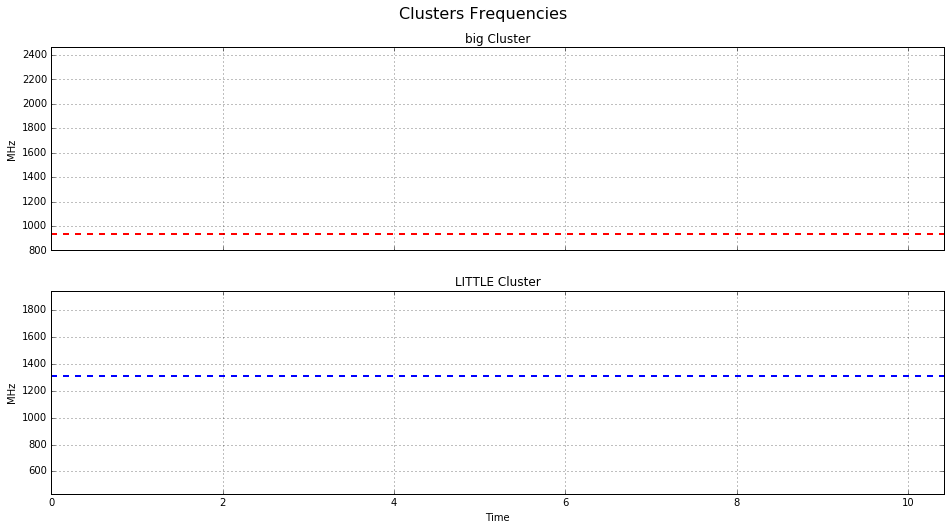

In [11]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass